In [3]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [4]:
channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_arrival = "SAROP11-PALMK118:ANALYSIS_PALM_DEL"                 #PALM arrival time

#Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator

In [3]:
scan_name ="jetx_7194_009"

# file names of the type below. copy paste for ease:
# FEL_knife_edge_Y_coarse_
# FEL_knife_edge_X_coarse_
# FEL_knife_edge_Y_fine_
# FEL_knife_edge_X_fine_

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

In [5]:
def LoadData_other_channels(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        PALM_arrival = BS_file[channel_PALM_arrival][:][reprate_FEL]
        
    return PALM_arrival

In [6]:
filename = DIR + scan_name + ".BSREAD.h5"
LoadData_other_channels(filename)

NameError: name 'DIR' is not defined

In [6]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Data_pumped = BS_file[channel_PIPS_fluo][:][reprate_laser]
        Data_unpumped = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        
        DataT_pumped = BS_file[channel_PIPS_trans][:][reprate_laser]
        DataT_unpumped = BS_file[channel_PIPS_trans][:][reprate_FEL]
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]
        
        Energy = BS_file[channel_energy][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        
    return Data_pumped, Data_unpumped, Izero_pump, Izero_unpump, Energy, Position, DataT_pumped, DataT_unpumped

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [7]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

ls: cannot access /sf/alvra/data/p17803/raw/scan_data/jetx_7194_009/: No such file or directory
ra-c-004.psi.ch


FileNotFoundError: [Errno 2] No such file or directory: '/sf/alvra/data/p17803/raw/scan_data/jetx_7194_009/'

In [244]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal_pump = []
Signal_unpump = []
err_signal = []

SignalT_pump = []
SignalT_unpump = []
err_signalT = []

Izero_pump = []
Izero_unpump = []
err_Izero = []
Izero_loop = []

Position_mm = []
Energy_eV = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        Signal_pump.append(np.mean(signal_pump_loop))
        Signal_unpump.append(signal_unpump_loop.mean())
        err_signal.append(signal_pump_loop.std()/np.sqrt(signal_pump_loop.size))
        
        SignalT_pump.append(np.mean(signalT_pump_loop))
        SignalT_unpump.append(signalT_unpump_loop.mean())
        err_signalT.append(signalT_pump_loop.std()/np.sqrt(signal_pump_loop.size))
        
        Izero_pump.append(Izero_pump_loop.mean())
        Izero_unpump.append(Izero_unpump_loop.mean())
       # err_Izero.append(Izero_loop.std()/np.sqrt(Izero_loop.size))
    
        energy_loop = [x for x in energy_loop if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_loop))
        Position_mm.append(np.mean(position_loop))
        
        print (signal_pump_loop.size,signal_unpump_loop.size)
    
Signal_pump = np.asarray(Signal_pump)
Signal_unpump = np.asarray(Signal_unpump)
err_signal = np.asarray(err_signal)
Izero_pump = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
err_Izero = np.asarray(err_Izero)

Energy_eV = np.asarray(Energy_eV)
Position_mm = np.asarray(Position_mm)
print ("Job done!")

/sf/alvra/data/p17803/res/scan_info/CytC_Fe2_monoscan_complete_009_scan_info.json
Processing 42 files
step 1 of 42 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0000.BSREAD.h5
1000 1000
step 2 of 42 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0001.BSREAD.h5
1000 1000
step 3 of 42 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0002.BSREAD.h5
1000 1000
step 4 of 42 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0003.BSREAD.h5
1000 1000
step 5 of 42 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0004.BSREAD.h5
1000 1000
step 6 of 42 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0005.

1.091930529802822
(1000, 1)


<IPython.core.display.Javascript object>


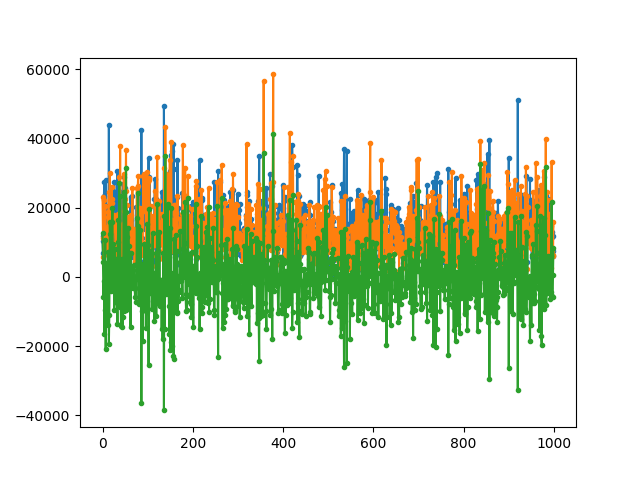

-137.7156534653477


In [231]:
print (signal_pump_loop.mean())
print (signal_unpump_loop.shape)
plt.figure()

plt.plot(Izero_pump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop-Izero_pump_loop, label="FEL+Laser",marker='.')

print (Izero_pump_loop.mean()- Izero_unpump_loop.mean())

<IPython.core.display.Javascript object>


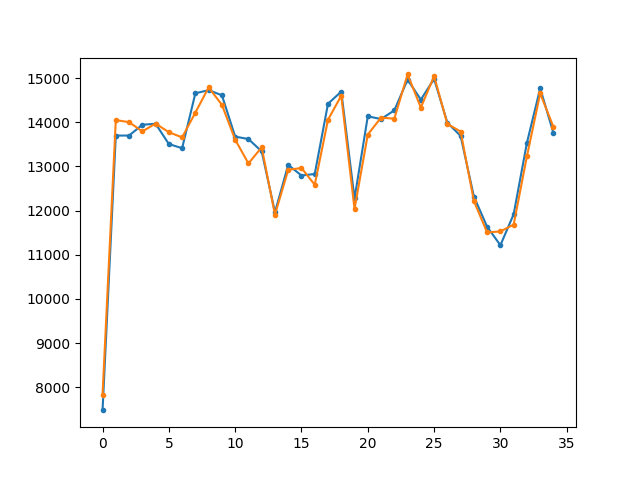

In [232]:
plt.figure()

plt.plot(Izero_pump, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump, label="FEL+Laser",marker='.')

In [245]:
Signal_pump_norm = Signal_pump / Izero_pump
Signal_unpump_norm = Signal_unpump / Izero_unpump


#Signal_pump_norm = np.log(-(Signal_pump / Izero_pump))
#Signal_unpump_norm = np.log(-(Signal_unpump / Izero_unpump))


#Signal_pump = Signal_pump 
#Signal_unpump_norm = Signal_unpump 

err_signal_norm = err_signal / Izero_pump

<IPython.core.display.Javascript object>


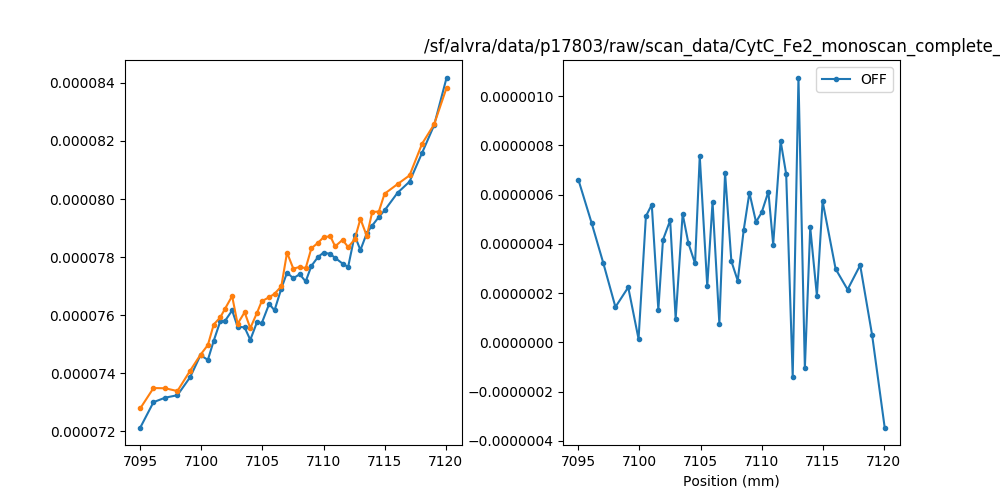

In [246]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(Energy_eV, Signal_pump_norm, label="ON",marker='.')
plt.plot(Energy_eV, Signal_unpump_norm, label="OFF",marker='.')
#plt.fill_between(Energy_eV, low_err, high_err, color='lightblue')
plt.subplot(1,2,2)
plt.plot(Energy_eV, Signal_unpump_norm-Signal_pump_norm, label="OFF",marker='.')

low_err= Signal_pump_norm - err_signal_norm
high_err= Signal_pump_norm + err_signal_norm

plt.title(DIR)
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3) 
plt.show()

#plt.savefig('Timescan_7_diode')

In [184]:
# Now fit with error funciton (defined above)
parameters,extras = curve_fit(errfunc, Position_mm, Signal_norm, p0 = [0, 0.1, 16.9, 0.05]) # [baseline, step amplitude, center, FWHM]

print("Position t0 =",np.abs(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

NameError: name 'Signal_norm' is not defined

<IPython.core.display.Javascript object>


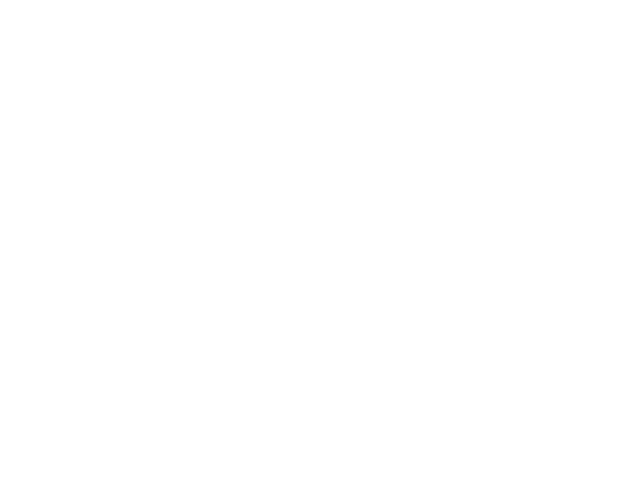

NameError: name 'Signal_norm' is not defined

In [185]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Position_mm, Signal_norm, label="scan_004",marker='.')
plt.plot(Position_mm, errfunc(Position_mm,*parameters))

low_err= Signal_norm - err_signal_norm
high_err= Signal_norm + err_signal_norm
plt.fill_between(Position_mm, low_err, high_err, color='lightblue')

plt.title(np.round(parameters[3]*1000, 3) )
plt.grid()
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_LAM_003')

In [18]:
myList = np.concatenate((np.arange(7100,7105,1), np.arange(7105,7120,0.5), np.arange(7120,7160,1),np.arange(7160,7200,3)))

In [146]:
myList

NameError: name 'myList' is not defined